In [ ]:
!nvidia-smi

Sat Jul  4 13:52:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -qq transformers

In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

In [ ]:
df = pd.read_csv("Train.csv")
df.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [ ]:
df.shape

(616, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      616 non-null    object
 1   text    616 non-null    object
 2   label   616 non-null    object
dtypes: object(3)
memory usage: 14.6+ KB


In [ ]:
df.label.value_counts()/len(df)

Depression    0.571429
Alcohol       0.227273
Suicide       0.107143
Drugs         0.094156
Name: label, dtype: float64

In [ ]:
class_names=['Depression','Alcohol','Suicide','Drugs']

In [ ]:
df['label']=df['label'].map({'Depression':0,'Alcohol':1,'Suicide':2,'Drugs':3})
df.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,0
1,9JDAGUV3,Why do I get hallucinations?,3
2,419WR1LQ,I am stresseed due to lack of financial suppor...,0
3,6UY7DX6Q,Why is life important?,2
4,FYC0FTFB,How could I be helped to go through the depres...,0


In [ ]:
df.label.value_counts()/len(df)

0    0.571429
1    0.227273
2    0.107143
3    0.094156
Name: label, dtype: float64

In [ ]:

# def pre_process_document(document):
#     # lower case
#     document = document.lower()
    
#     return document


# df['text']=df['text'].apply(pre_process_document)
# df.head()

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

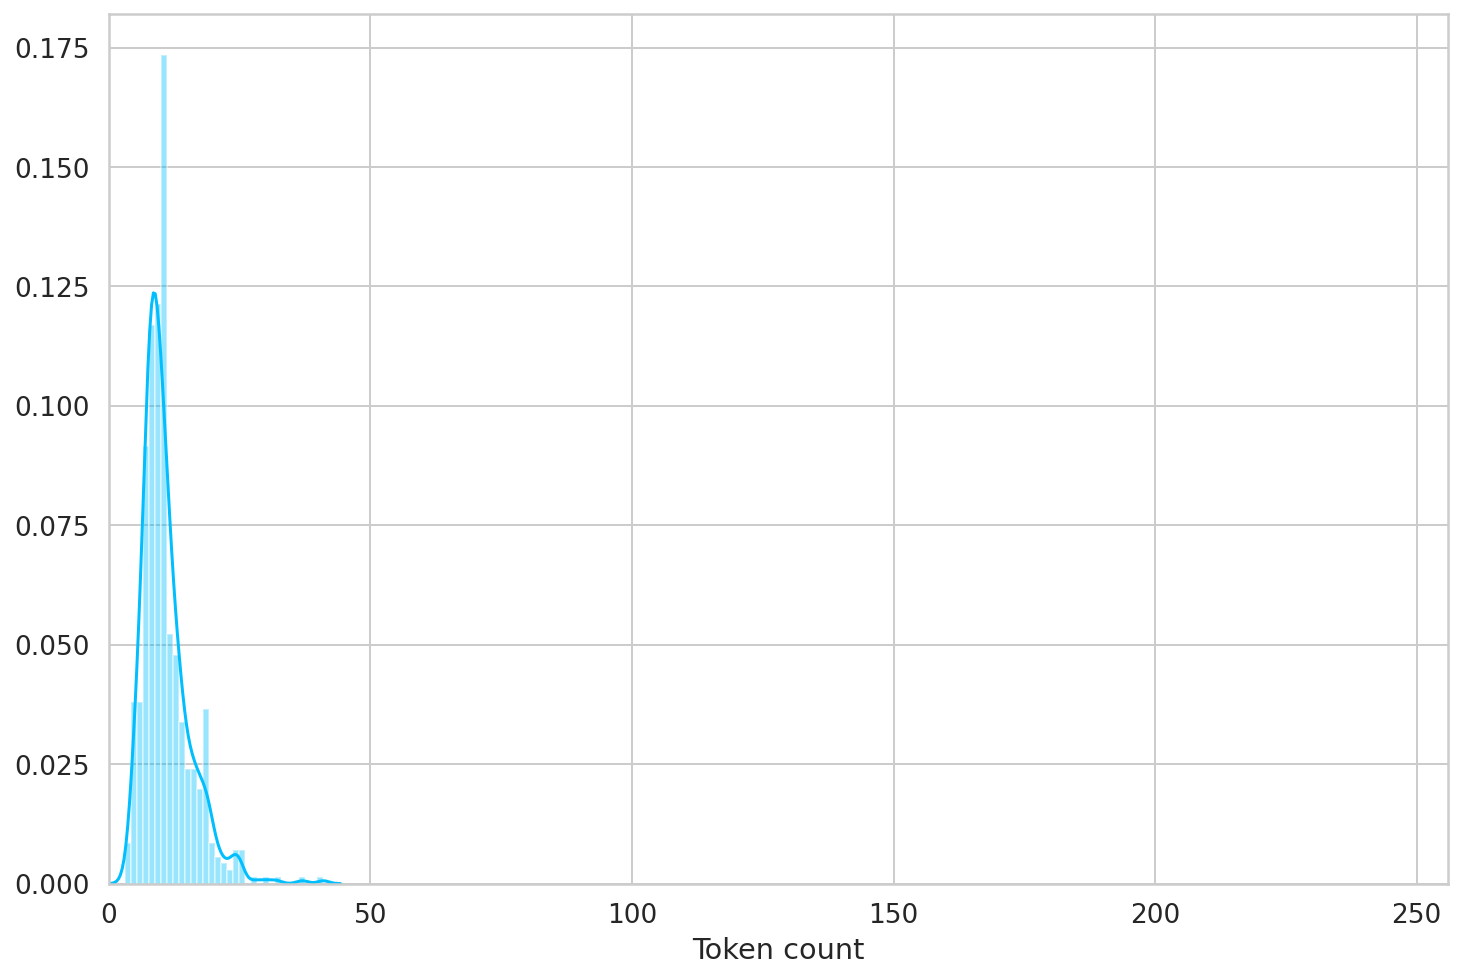

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 64

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((492, 3), (62, 3), (62, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 64])
torch.Size([16, 64])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 64])
torch.Size([16, 64])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3382, 0.1460, 0.3460, 0.1698],
        [0.4387, 0.1184, 0.3021, 0.1409],
        [0.2269, 0.1125, 0.5253, 0.1354],
        [0.4868, 0.0948, 0.2880, 0.1304],
        [0.4858, 0.1397, 0.2141, 0.1604],
        [0.2843, 0.1288, 0.4414, 0.1455],
        [0.3477, 0.1167, 0.4008, 0.1348],
        [0.2469, 0.1946, 0.3666, 0.1919],
        [0.2851, 0.1564, 0.4374, 0.1211],
        [0.1897, 0.1582, 0.4591, 0.1930],
        [0.3293, 0.1344, 0.3715, 0.1648],
        [0.3724, 0.1529, 0.3515, 0.1232],
        [0.3831, 0.0776, 0.2788, 0.2605],
        [0.3783, 0.1168, 0.3111, 0.1937],
        [0.3157, 0.1222, 0.3550, 0.2071],
        [0.2836, 0.1586, 0.4093, 0.1485]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.8411705292040302 accuracy 0.6524390243902439
Val   loss 0.6586809605360031 accuracy 0.7580645161290323

Epoch 2/4
----------
Train loss 0.3366611860692501 accuracy 0.8699186991869919
Val   loss 0.45514291524887085 accuracy 0.8548387096774194

Epoch 3/4
----------
Train loss 0.15859348574773438 accuracy 0.9430894308943091
Val   loss 0.3929990101605654 accuracy 0.9032258064516129

Epoch 4/4
----------
Train loss 0.0879128647427405 accuracy 0.9776422764227644
Val   loss 0.4826783500611782 accuracy 0.8709677419354839

CPU times: user 16.9 s, sys: 10.2 s, total: 27.1 s
Wall time: 30.1 s


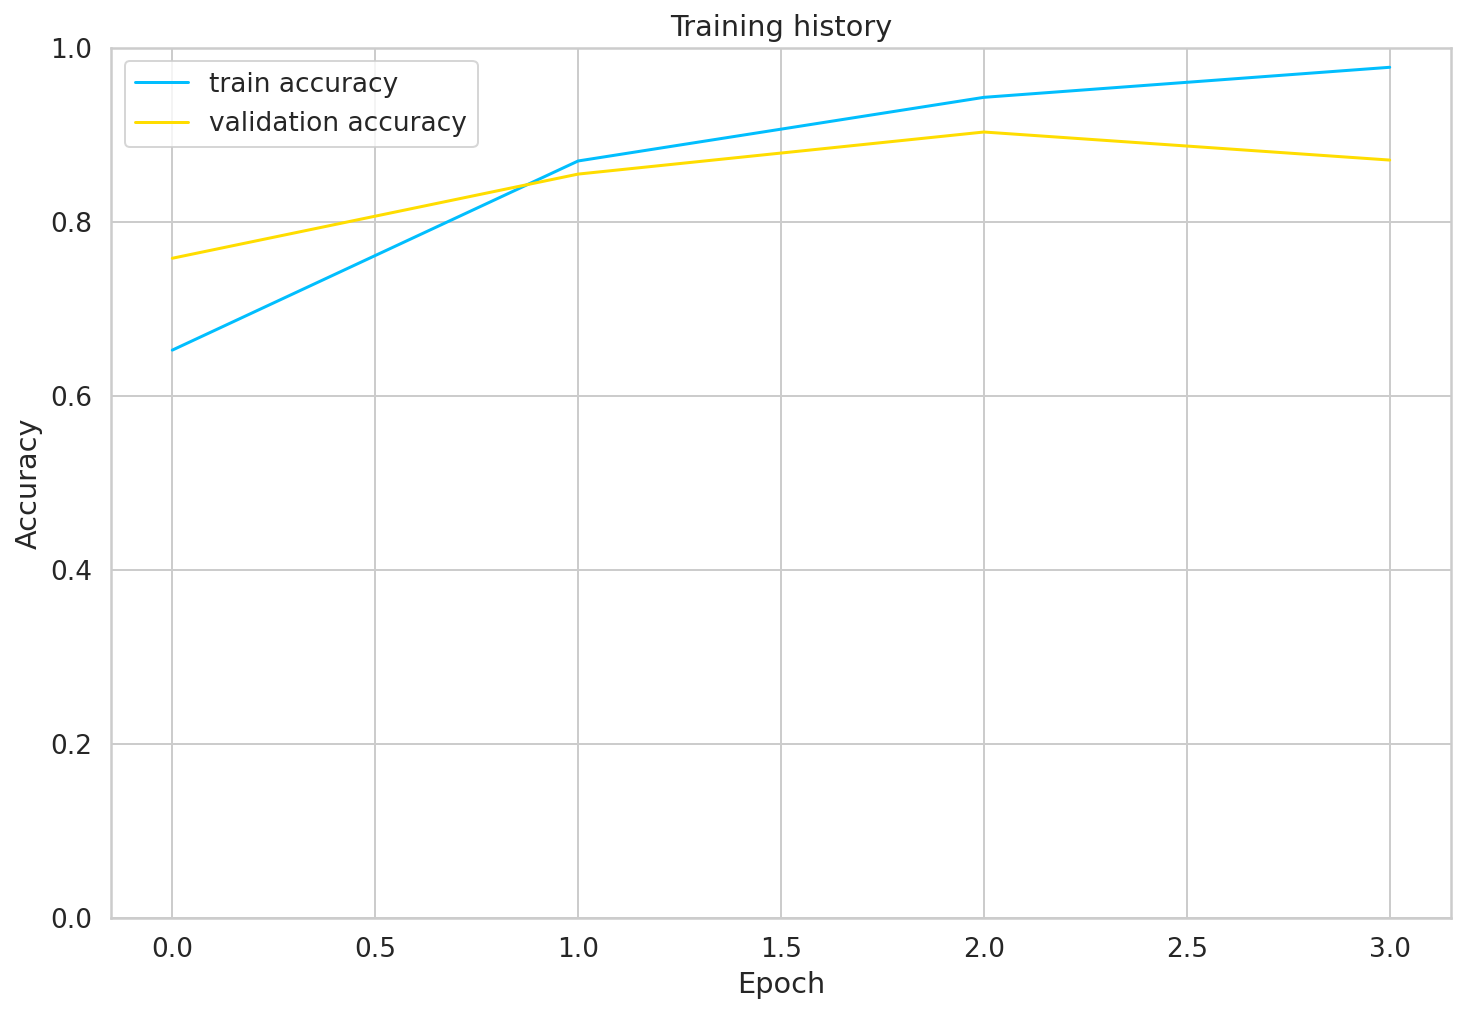

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8548387096774194

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

  Depression       0.94      0.88      0.91        33
     Alcohol       0.82      0.93      0.87        15
     Suicide       0.56      0.83      0.67         6
       Drugs       1.00      0.62      0.77         8

    accuracy                           0.85        62
   macro avg       0.83      0.82      0.80        62
weighted avg       0.88      0.85      0.86        62



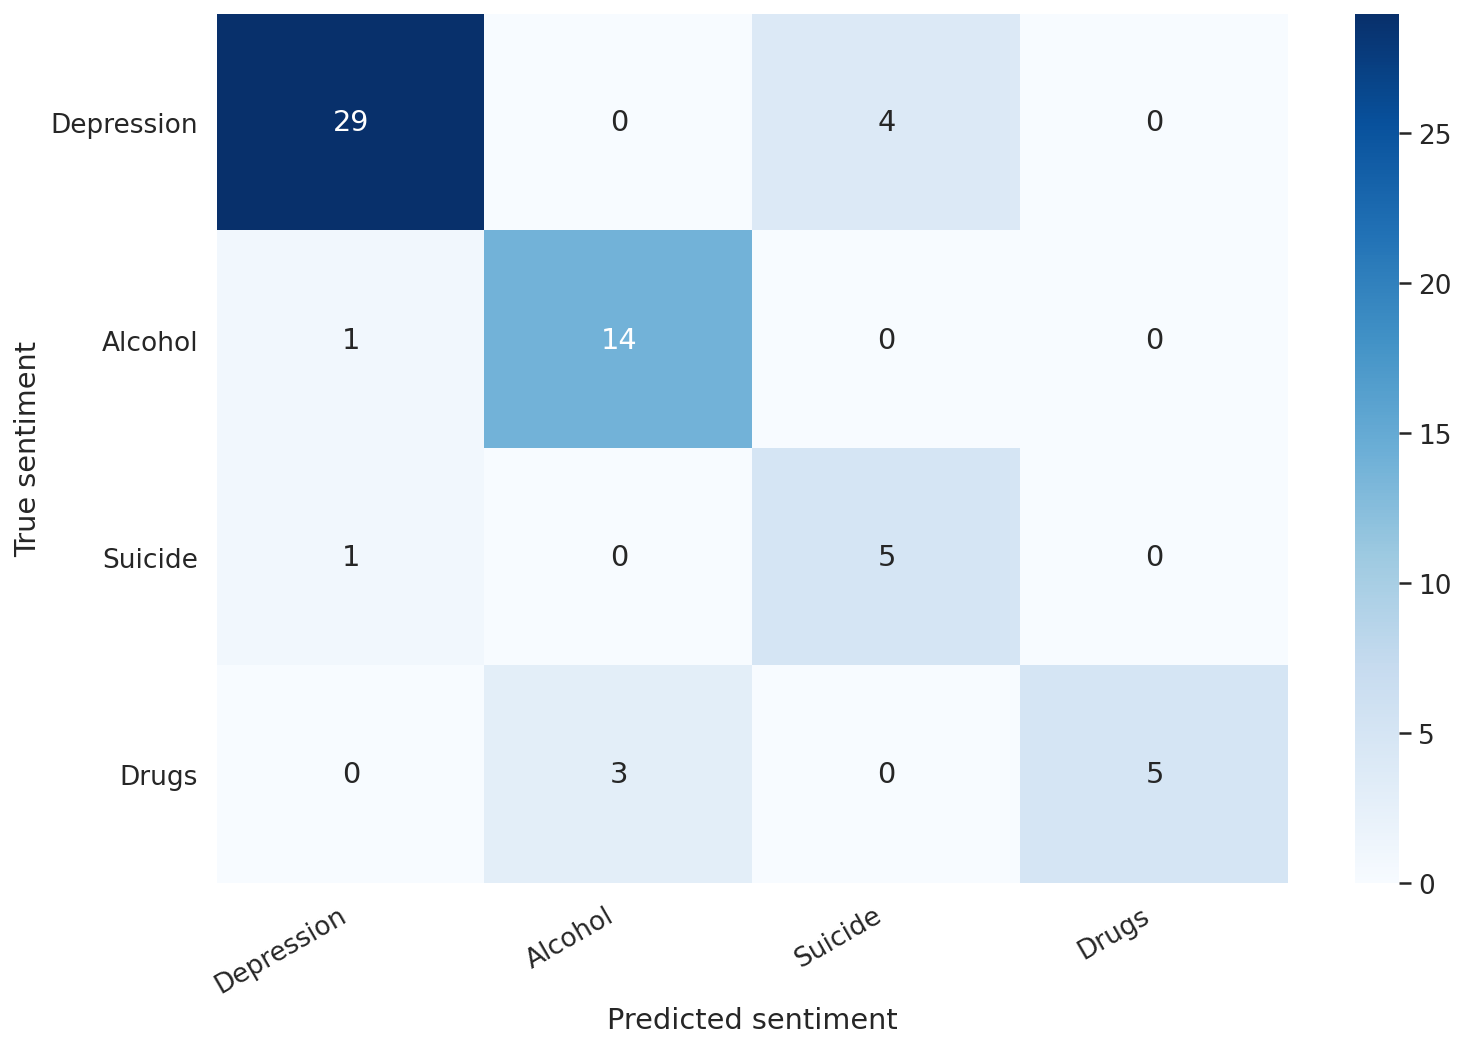

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
final_test=pd.read_csv('Test.csv')
final_test['label']=1
final_test.head()

,ID,text,label
0,02V56KMO,How to overcome bad feelings and emotions,1
1,03BMGTOK,I feel like giving up in life,1
2,03LZVFM6,I was so depressed feel like got no strength t...,1
3,0EPULUM5,I feel so low especially since I had no one to...,1
4,0GM4C5GD,can i be successful when I am a drug addict?,1


In [ ]:
# final_test['text']=final_test['text'].apply(pre_process_document)
# final_test.head()

In [ ]:
final_test_data_loader = create_data_loader(final_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
final_y_review_texts, final_y_pred, final_y_pred_probs, final_y_test = get_predictions(
  model,
  final_test_data_loader
)

In [ ]:
final_y_pred_probs=final_y_pred_probs.t()

In [ ]:
sub=pd.read_csv('SampleSubmission.csv')
sub.head()

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0,0,0,0
1,03BMGTOK,0,0,0,0
2,03LZVFM6,0,0,0,0
3,0EPULUM5,0,0,0,0
4,0GM4C5GD,0,0,0,0


In [ ]:
sub['Depression']=final_y_pred_probs[0]
sub['Alcohol']=final_y_pred_probs[1]
sub['Suicide']=final_y_pred_probs[2]
sub['Drugs']=final_y_pred_probs[3]


In [ ]:
sub.head()

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0.984965,0.002217,0.012109,0.000708
1,03BMGTOK,0.997586,0.000557,0.001551,0.000306
2,03LZVFM6,0.997559,0.000631,0.001527,0.000283
3,0EPULUM5,0.997657,0.000575,0.001479,0.000289
4,0GM4C5GD,0.003031,0.575993,0.026984,0.393993


In [ ]:
sub.to_csv('MentalSubmission.csv',index=False)
